In [169]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# test
# data_test_path = 'data/test/'
# df1 = f'{data_test_path}test_1.fastq'
# df2 = f'{data_test_path}test_2.fastq'
# genome = f'{data_test_path}MG1655-K12.first10K.fasta'

# prod
data_path = 'data/E.coli/'
df1_1 = f'{data_path}100x.1.fastq'
df1_2 = f'{data_path}100x.2.fastq'
df2_1 = f'{data_path}ecoli_mda_lane1_left.downsampled.fastq'
df2_2 = f'{data_path}ecoli_mda_lane1_right.downsampled.fastq'
genome = f'{data_path}MG1655-K12.fasta'

# 0. Разбораться с bwa mem

Будем использовать bwa mem

Построим индекс:

In [170]:
!bwa index {genome}

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.14 seconds elapse.
[bwa_index] Update BWT... 0.02 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.27 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/E.coli/MG1655-K12.fasta
[main] Real time: 1.506 sec; CPU: 1.512 sec


Строим выравнивание:

In [44]:
!bwa mem {genome} {df1_1} {df1_2} > {data_path}alignment1.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48198, 0, 1)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.45, 10.19)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 2.989 CPU sec, 2.926 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48239, 0, 0)
[M::mem_pestat] skip orientat

[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48165, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.44, 10.16)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 3.417 CPU sec, 3.248 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48104, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orienta

[M::mem_process_seqs] Processed 100000 reads in 3.315 CPU sec, 3.158 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48151, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.43, 10.19)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 3.344 CPU sec, 3.179 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48203, 0, 0)
[M::mem_pestat] skip orientation FF as there are n

[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48162, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.37, 10.21)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 3.143 CPU sec, 2.997 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48220, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orienta

[M::mem_process_seqs] Processed 100000 reads in 3.294 CPU sec, 3.127 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48142, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.39, 10.14)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 3.297 CPU sec, 3.129 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48133, 0, 1)
[M::mem_pestat] skip orientation FF as there are n

In [45]:
!bwa mem {genome} {df2_1} {df2_2} > {data_path}alignment2.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (112, 44880, 44, 139)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (890, 2400, 4678)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12254)
[M::mem_pestat] mean and std.dev: (3073.67, 2476.43)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 16042)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (249, 279, 299)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (149, 399)
[M::mem_pestat] mean and std.dev: (277.18, 39.54)
[M::mem_pestat] low and high boundaries for proper pairs: (99, 449)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50

[M::mem_process_seqs] Processed 100000 reads in 3.543 CPU sec, 3.402 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (120, 45065, 37, 130)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1121, 2446, 5713)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14897)
[M::mem_pestat] mean and std.dev: (3451.37, 2748.10)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19489)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (252, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (156, 396)
[M::mem_pestat] mean and std.dev: (279.36, 36.53)
[M::mem_pestat] low and high boundaries for proper pairs: (108, 444)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 4.101 CPU sec, 3.948 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (145, 45005, 36, 145)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1085, 2696, 5079)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13067)
[M::mem_pestat] mean and std.dev: (3306.94, 2619.11)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17061)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (255, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (165, 390)
[M::mem_pestat] mean and std.dev: (281.63, 33.54)
[M::mem_pestat] low and high boundaries for proper pairs: (120, 435)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.334 CPU sec, 3.182 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (106, 45171, 47, 151)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1166, 2844, 5356)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13736)
[M::mem_pestat] mean and std.dev: (3508.18, 2735.13)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17926)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (255, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (165, 390)
[M::mem_pestat] mean and std.dev: (281.74, 33.46)
[M::mem_pestat] low and high boundaries for proper pairs: (120, 435)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.264 CPU sec, 3.113 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (130, 44672, 48, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (882, 2483, 5545)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14871)
[M::mem_pestat] mean and std.dev: (3287.26, 2720.82)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19534)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (256, 281, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (168, 388)
[M::mem_pestat] mean and std.dev: (282.32, 32.78)
[M::mem_pestat] low and high boundaries for proper pairs: (124, 432)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (2

[M::mem_process_seqs] Processed 100000 reads in 3.163 CPU sec, 3.011 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (124, 44827, 48, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1443, 2989, 5470)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13524)
[M::mem_pestat] mean and std.dev: (3720.62, 2739.13)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17551)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (257, 281, 301)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (169, 389)
[M::mem_pestat] mean and std.dev: (282.81, 32.07)
[M::mem_pestat] low and high boundaries for proper pairs: (125, 433)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.212 CPU sec, 3.054 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (140, 43430, 44, 133)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1465, 3313, 5407)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13291)
[M::mem_pestat] mean and std.dev: (3581.09, 2540.76)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17233)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (237, 279, 299)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (113, 423)
[M::mem_pestat] mean and std.dev: (265.69, 54.37)
[M::mem_pestat] low and high boundaries for proper pairs: (48, 485)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (2

[M::mem_process_seqs] Processed 100000 reads in 3.032 CPU sec, 2.874 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (125, 44867, 40, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1382, 2942, 5658)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14210)
[M::mem_pestat] mean and std.dev: (3549.59, 2723.99)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 18486)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.55, 35.09)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.040 CPU sec, 2.890 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (142, 45011, 46, 122)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1312, 2806, 4943)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12205)
[M::mem_pestat] mean and std.dev: (3323.96, 2500.05)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 15836)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.72, 34.72)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.127 CPU sec, 2.960 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (111, 45009, 37, 137)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 3107, 5881)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 15003)
[M::mem_pestat] mean and std.dev: (3840.86, 2853.29)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19564)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.63, 34.88)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 4.520 CPU sec, 4.371 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (121, 44644, 32, 152)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1202, 2372, 5393)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13775)
[M::mem_pestat] mean and std.dev: (3489.26, 2846.81)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17966)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (250, 279, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (150, 400)
[M::mem_pestat] mean and std.dev: (277.66, 39.05)
[M::mem_pestat] low and high boundaries for proper pairs: (100, 450)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 3.081 CPU sec, 2.921 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (129, 45132, 48, 133)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1215, 2842, 6161)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 16053)
[M::mem_pestat] mean and std.dev: (3624.22, 2761.49)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 20999)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (250, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (150, 400)
[M::mem_pestat] mean and std.dev: (277.67, 39.15)
[M::mem_pestat] low and high boundaries for proper pairs: (100, 450)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

Определяем процент приложившихся ридов:

In [46]:
!samtools flagstat {data_path}alignment1.sam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [47]:
!samtools flagstat {data_path}alignment2.sam

5869326 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
40560 + 0 supplementary
0 + 0 duplicates
5706946 + 0 mapped (97.23% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5151500 + 0 properly paired (88.38% : N/A)
5647486 + 0 with itself and mate mapped
18900 + 0 singletons (0.32% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


99.82% ридов приложилось для 1 датасета

97.23% ридов приложилось для 2 датасета

# 1. Покрытие генома

Превратим sam файл в bam, отсортируем и проиндексируем его 

In [48]:
!samtools view -b {data_path}alignment1.sam > {data_path}alignment1.bam
!samtools sort {data_path}alignment1.bam > {data_path}alignment1.sorted.bam
!samtools index {data_path}alignment1.sorted.bam

!samtools view -b {data_path}alignment2.sam > {data_path}alignment2.bam
!samtools sort {data_path}alignment2.bam > {data_path}alignment2.sorted.bam
!samtools index {data_path}alignment2.sorted.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...
[bam_sort_core] merging from 2 files and 1 in-memory blocks...


Посчитаем покрытие

Доля покрытой области: 100.0 %


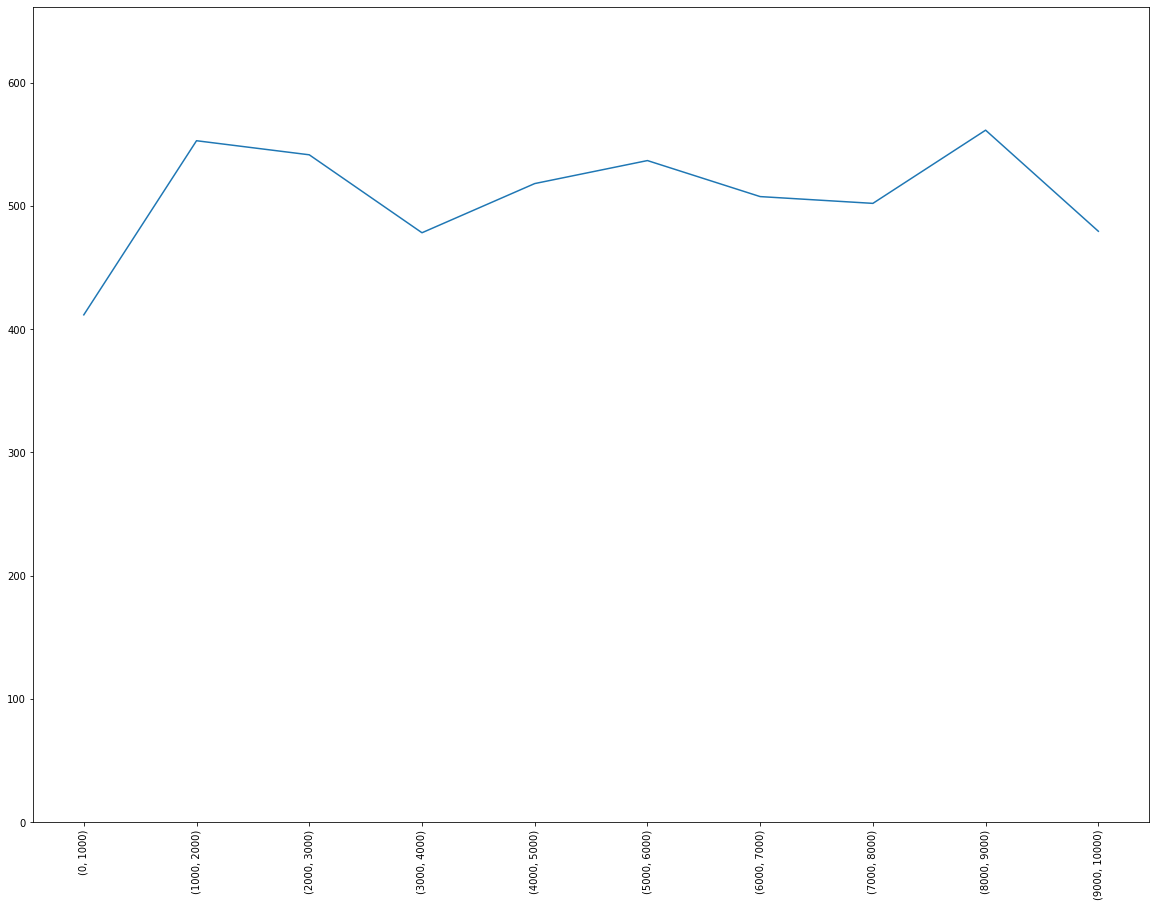

Доля покрытой области: 99.99989223383103 %


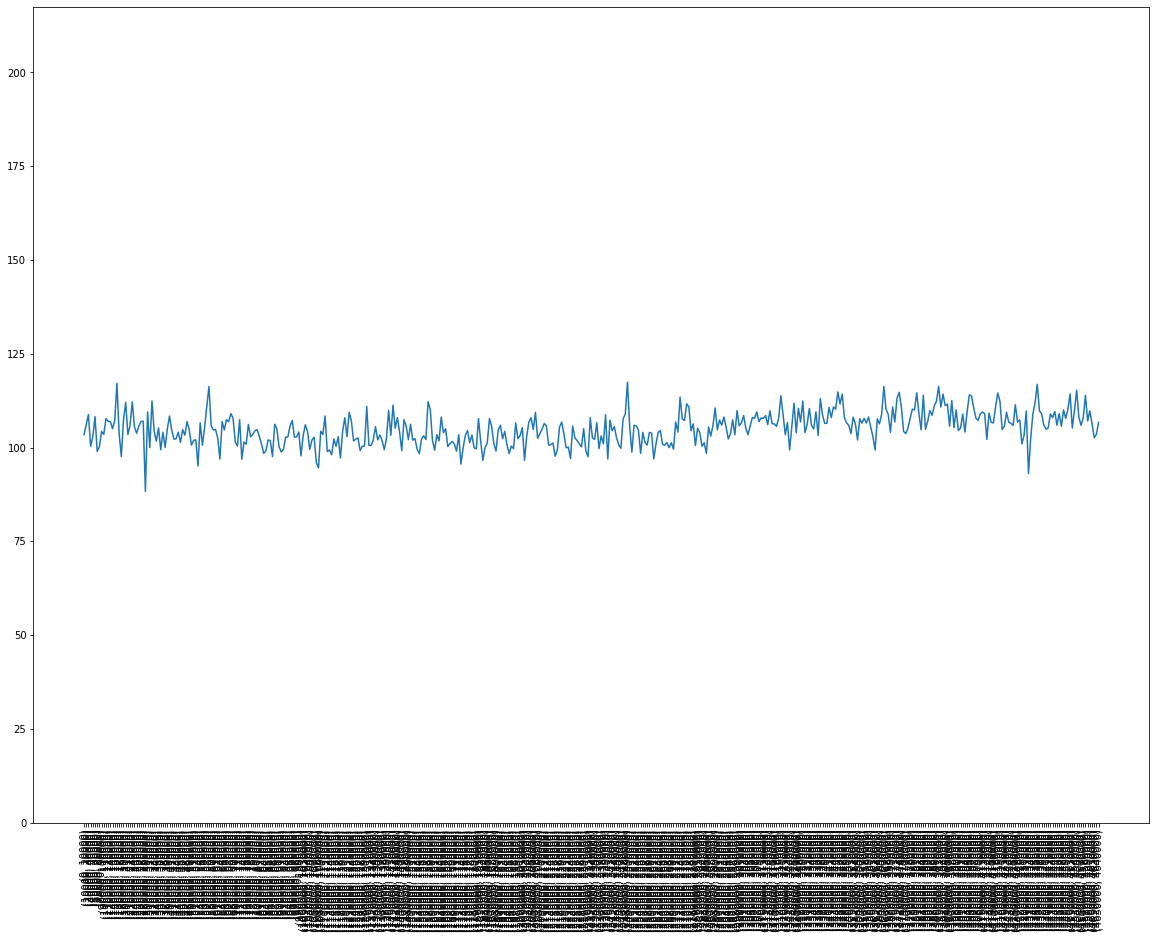

Доля покрытой области: 96.53383049459283 %


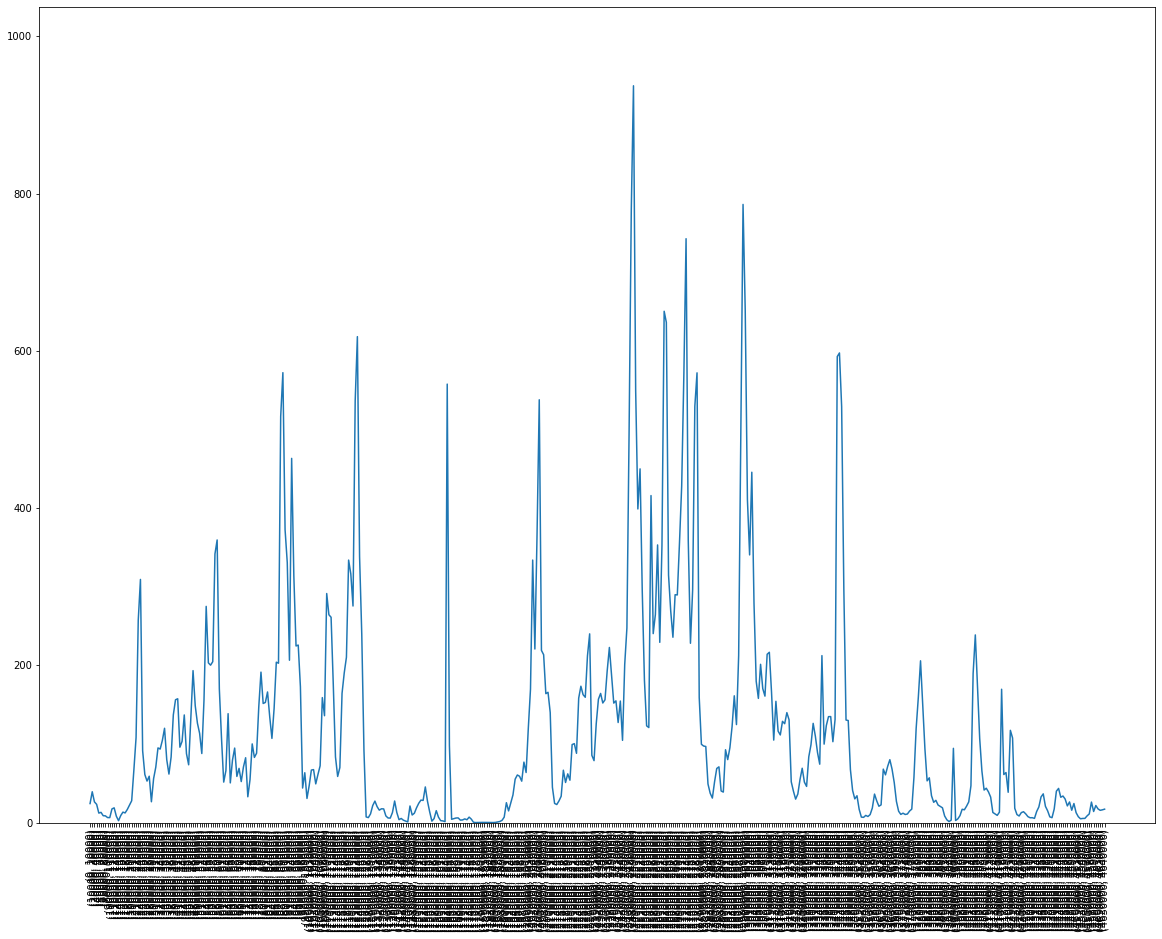

In [101]:
def coverage(al_path, avg=1000):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    ref_len = bamfile.get_reference_length(ref_name)
    
    pos_cov = np.array([0] * ref_len)
    
    for line in bamfile:
        blocks = line.get_blocks()
        if len(blocks) > 0:
            cov = blocks[0]
            pos_cov[cov[0]: cov[1]] += 1
    
    pos_cov_avg = []
    pos_cov_avg_lab = []
    
    for i in range(0, len(pos_cov), avg):
        pos_cov_avg_lab.append(f'({i}, {i + avg})')
        pos_cov_avg.append(pos_cov[i: i + avg].mean())
    
    cov_prop = len(pos_cov[pos_cov != 0]) / len(pos_cov)
    
    print('Доля покрытой области:', cov_prop * 100, '%')
    
    plt.figure(figsize=(20, 15))
    plt.plot(pos_cov_avg_lab, pos_cov_avg)
    plt.xticks(rotation='vertical')
    plt.ylim([0, max(pos_cov_avg) + 100])
    plt.show()

# запускаем на тестовых данных и двух датасетах
coverage(f'{data_test_path}alignment.sorted.bam')
coverage(f'{data_path}alignment1.sorted.bam', avg=10000)
coverage(f'{data_path}alignment2.sorted.bam', avg=10000)

# 2. Распределение расстояния вставки

среднее расстояние вставки: 215.2860440340909
среднеквадратичное отклонение: 10.590040942453138
интервал минимальной ширины, в который попадает 95% ридов: (195, 233)


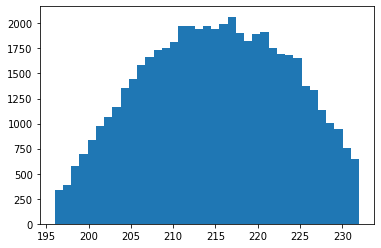

среднее расстояние вставки: 956.5563269548079
среднеквадратичное отклонение: 44686.33174939256
интервал минимальной ширины, в который попадает 95% ридов: (195, 234)


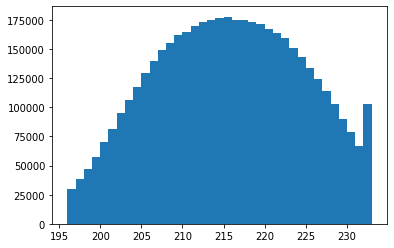

среднее расстояние вставки: 31314.689419364335
среднеквадратичное отклонение: 246217.1786722348
интервал минимальной ширины, в который попадает 95% ридов: (0, 332)


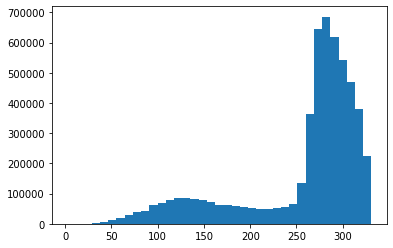

In [144]:
def insert_size(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    
    insert_sizes = []
    
    for line in bamfile:
        insert_sizes.append(abs(line.template_length))
    
    insert_sizes = np.array(insert_sizes)
    print('среднее расстояние вставки:', insert_sizes.mean())
    print('среднеквадратичное отклонение:', insert_sizes.std())
    
    insert_sizes.sort()
    width = int(len(insert_sizes) * 0.95) + 1
    
    low = 0
    high = low + width
    min_w = insert_sizes[high] - insert_sizes[low]
    
    for i in range(len(insert_sizes)):
        if i + width >= len(insert_sizes):
            break
        new_w = insert_sizes[i + width] - insert_sizes[i]
        if min_w > new_w:
            min_w = new_w
            low = i
            high = i + width
    
    print('интервал минимальной ширины, в который попадает 95% ридов:',
          (insert_sizes[low], insert_sizes[high]))
    
    # строим только 95% интервал чтобы избежать выбросов
    plt.hist(insert_sizes[(insert_sizes > insert_sizes[low]) & (insert_sizes < insert_sizes[high])], bins=37)
    plt.show()

# запускаем на тестовых данных и двух датасетах
insert_size(f'{data_test_path}alignment.sorted.bam')
insert_size(f'{data_path}alignment1.sorted.bam')
insert_size(f'{data_path}alignment2.sorted.bam')

# 3. Частоты различных замен

In [167]:
def repl_freq(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    
    freq = {
        'A': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'C': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'G': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'T': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'N': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0}
    }
    
    errors = []
    
    for line in bamfile.fetch(ref_name):
        query_length = line.query_length
        err_num = 0
        try:
            for p in line.get_aligned_pairs(with_seq=True):
                if p[2] in ['a', 'c', 'g', 't', 'n']:
                    freq[line.query_sequence[p[0]]][p[2].upper()] += 1
                    err_num += 1
        except:
            continue
        
        errors.append(err_num / query_length)
    
    print(pd.DataFrame(freq))
    print('avg error:', np.array(errors).mean() * 100, '%')

# запускаем на тестовых данных и двух датасетах
print('test')
repl_freq(f'{data_test_path}alignment.sorted.bam')

print('df1')
repl_freq(f'{data_path}alignment1.sorted.bam')

print('df2')
repl_freq(f'{data_path}alignment2.sorted.bam')

test
   A   C   G   T  N
A  0  15  19   1  0
C  0   0   2   1  0
G  0  21   0  34  0
T  0   0  16   0  0
N  0   0   0   0  0
avg error: 0.002567403486838207 %
df1
        A       C       G       T      N
A       0  637340  380536  145879  84469
C  272766       0  240021  157971  84271
G  159165  241260       0  273569  84532
T  146392  379576  637018       0  84100
N       0       0       0       0      0
avg error: 0.8031547312105539 %
df2
        A       C       G       T       N
A       0  616006  377466  168711  204490
C  282365       0  219045  175047  198160
G  175310  223157       0  277789  196474
T  170488  381076  604303       0  202196
N       0       0       0       0       0
avg error: 0.7860450757245909 %


# 4. Статистика ридов IonTorrent

In [184]:
# test
data_path = 'data/ion/'
df = f'{data_path}test.fastq'
genome_t = f'{data_path}test_reference.fasta'

# prod
df1 = f'{data_path}B22-730.fastq'
df2 = f'{data_path}C24-698.fastq'
genome = f'{data_path}DH10B-K12.fasta'

In [185]:
!bwa index {genome_t}
!bwa index {genome}

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 2.10 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.47 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ion/test_reference.fasta
[main] Real time: 2.696 sec; CPU: 2.699 sec
[bwa_index] Pack FASTA... 0.03 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.12 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.27 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ion/DH10B-K12.fasta
[main] Real time: 1.476 sec; CPU: 1.482 sec


In [186]:
!bwa mem {genome_t} {df} > {data_path}alignment.sam
!bwa mem {genome} {df1} > {data_path}alignment1.sam
!bwa mem {genome} {df2} > {data_path}alignment2.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 250 sequences (82521 bp)...
[M::mem_process_seqs] Processed 250 reads in 0.036 CPU sec, 0.036 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem data/ion/test_reference.fasta data/ion/test.fastq
[main] Real time: 0.044 sec; CPU: 0.059 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30580 sequences (10000589 bp)...
[M::process] read 30700 sequences (10000499 bp)...
[M::mem_process_seqs] Processed 30580 reads in 4.392 CPU sec, 4.356 real sec
[M::process] read 30654 sequences (10000464 bp)...
[M::mem_process_seqs] Processed 30700 reads in 4.794 CPU sec, 4.732 real sec
[M::process] read 30558 sequences (10000069 bp)...
[M::mem_process_seqs] Processed 30654 reads in 5.202 CPU sec, 5.132 real sec
[M::process] read 30468 sequences (10000148 bp)...
[M::mem_process_seqs] Processed 30558 reads in 4.032 CPU sec, 3.959 real sec
[M::process] read 30596 sequences (10000413 bp)...
[M::mem_process_seqs] Proces

In [188]:
!samtools flagstat {data_path}alignment.sam

250 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 mapped (0.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


ничего не выровнялось на тестовом, не будем его использовать впоследствии

In [187]:
!samtools flagstat {data_path}alignment1.sam

497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [189]:
!samtools flagstat {data_path}alignment2.sam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [190]:
!samtools view -b {data_path}alignment1.sam > {data_path}alignment1.bam
!samtools sort {data_path}alignment1.bam > {data_path}alignment1.sorted.bam
!samtools index {data_path}alignment1.sorted.bam

!samtools view -b {data_path}alignment2.sam > {data_path}alignment2.bam
!samtools sort {data_path}alignment2.bam > {data_path}alignment2.sorted.bam
!samtools index {data_path}alignment2.sorted.bam

Покрытие генома

Доля покрытой области: 99.96077792860089 %


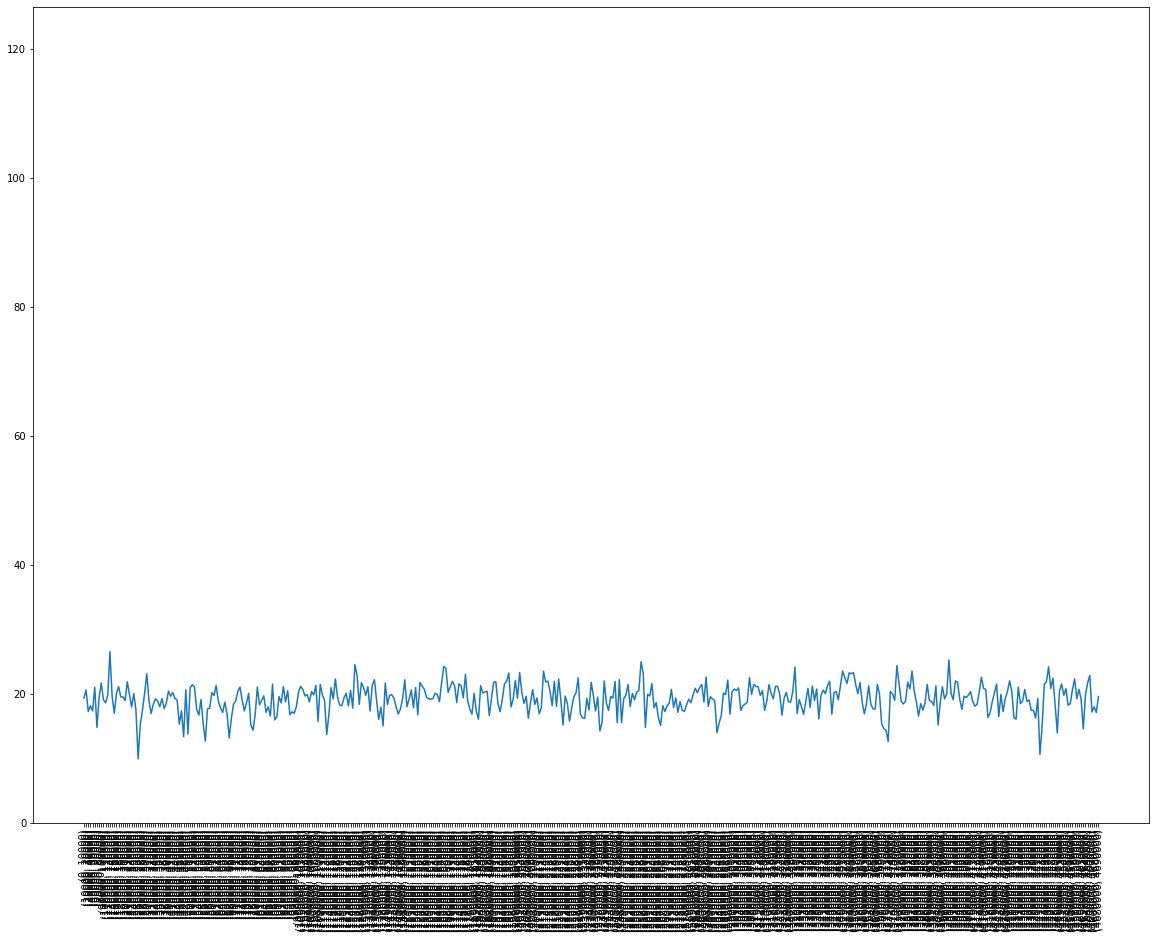

Доля покрытой области: 99.99664969248659 %


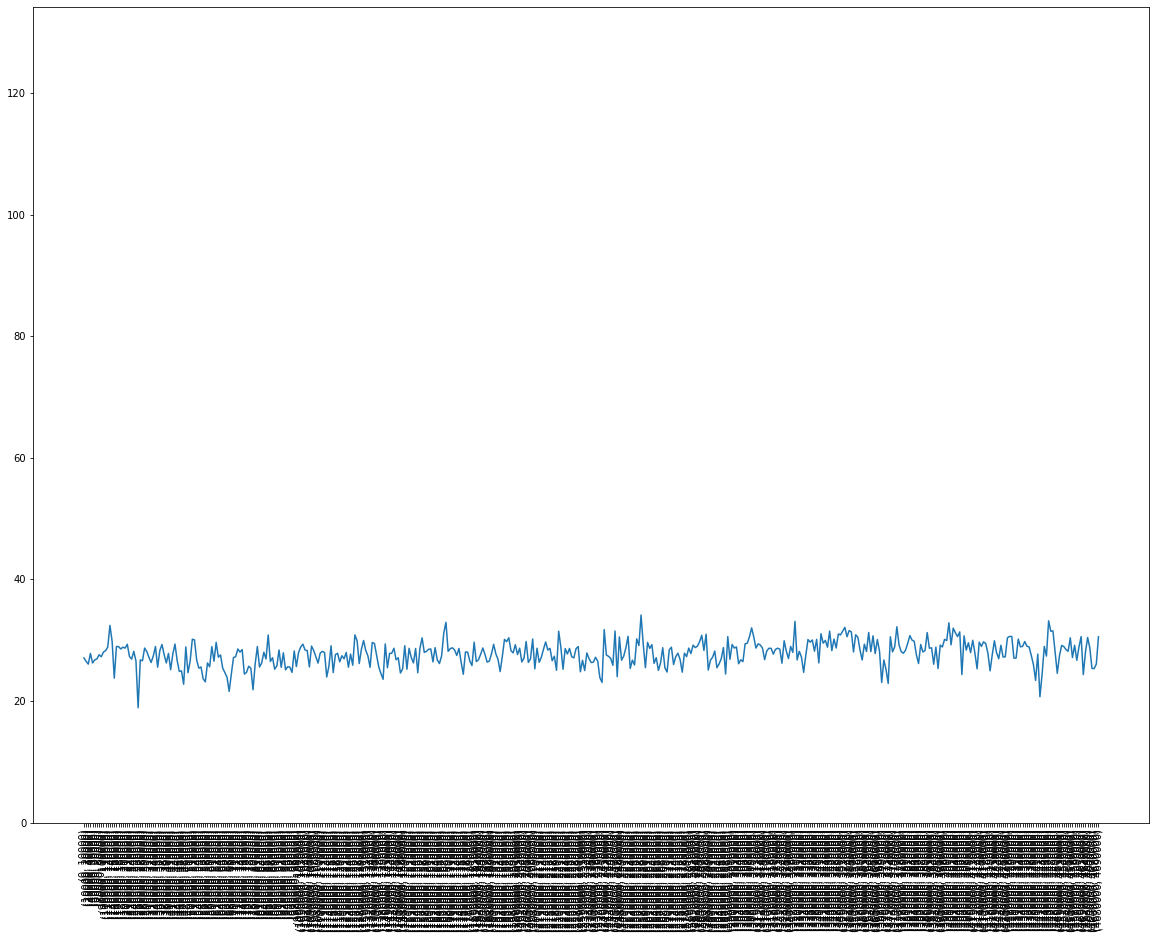

In [191]:
coverage(f'{data_path}alignment1.sorted.bam', avg=10000)
coverage(f'{data_path}alignment2.sorted.bam', avg=10000)